#### Task 1: Produce datasets of hourly data at selected global 9 cities (1979-2020)  
The cities are Los Angeles (USA), Mexico City (Mexico), London (UK), Paris (France), Cairo (Egypt), Sharm El-Sheikh (Egypt), Dubai, Manila (Philippines), and Sydney (Australia).(use the closest *land* grid point to these cities and avoid any ocean data points).

write to text files for each variable with columns of 9 cities:
 grid point lat, grid point lon, yyyymmddhh, 
 variables are: 2m temperature, 2m dew-point temperature, 2m wet-bulb temperature, 10m U wind, 10m V wind

#### Task 2:  
For each of the 9 cities, use the hourly 2m wet-bulb temperature timeseries data from Task 1 and convert to daily maximum value of 2m wet-bulb temperature to calculate characteristics
 - i) duration (days), 
 - ii) max value of wet-bulb temperature over the sequence
 - iii) start date.

In [1]:
import os.path
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage 
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import datetime
import glob
import geopy
from geopy.geocoders import Nominatim

In [2]:
def plot_9city(flnm):
    # use first column as index
    df_d = pd.read_csv(flnm, index_col = 0)
    # Converting the index as date
    date_s = pd.to_datetime(df_d.index)
    yyyymmddhh = date_s.format(formatter=lambda x: x.strftime('%Y%m%d%H'))
    df_d.index = yyyymmddhh
    df_d.plot(figsize=(20, 10))

def format_9city_csv(flnm_i, flnm_o):
    # first column as index
    df_t = pd.read_csv(flnm_i, index_col = 0)
    # Converting the index as date
    date_s = pd.to_datetime(df_t.index)
    yyyymmddhh = date_s.format(formatter=lambda x: x.strftime('%Y%m%d%H'))
    df_t.index = yyyymmddhh
    
    # Round each number in a Python pandas data frame by 2 decimals
    df_t.round(2)
    df_t.round(2).to_csv(flnm_o) 


In [61]:
def create_df(df_9city, thresh_s):
    '''
    df_9city: dataframe of wet-bulb temperature of 9 cities
              the dataframe put those values < threshold to nan
    thresh_s: threshold as string used in output filenmae
    
    1 calculate characteristics of each sequence from df_9city dataframe
    2 create a new dataframe from those characters 
    3 write out the new dataframe
    '''
    for (cityName, twb) in df_9city.iteritems():
        # type(twb):<class 'pandas.core.series.Series'>, type(cityName): str
         
        # get index
        ind_value = df_9city[df_9city[cityName]>0].index.values
        n_value = len(ind_value)
        
        # Select values (Rows) by Index
        if n_value > 0:
            twb_1d = df_9city[cityName].values
            ind_df = df_9city.index
            # I put threshold 0 for consecutive_character to get rid of NaN 
            # because we use 28, 30, P90 as threshold, which > 0
            ind_st_1d, obj_len_1d, obj_max_1d = consecutive_character(twb_1d, 0) 
        
            # create a new dtaFrame
            df_new = pd.DataFrame({'start date':ind_df[ind_st_1d], 'duration': obj_len_1d, 'twb max': obj_max_1d})
             
            flnm_o = cityName + '_' + thresh_s + '.csv'
            print('output:',flnm_o)
            df_new.round(2).to_csv(flnm_o) 

In [63]:
def consecutive_character(arr_1d, threshold):
    '''
    find the consecutive arr_1d > threshold
    each period's 
     (1) 1st index of each obj (0-based)
     (2) the duration of each obj
     (3) the maximum value of each obj
    '''
    PR_bin = arr_1d > threshold

    # Label features in an array. It returns label and the number of obj
    PR_label, n_obj = (ndimage.label(PR_bin)) 
    
    ind_st_1d = []
    obj_max_1d = []
    for no in range(1, n_obj+1):
        # get the first index value
        ind_st_1d.append(np.where(PR_label==no)[0][0])
        # the the maximum valude of each obj or period
        obj_max = max(arr_1d[np.where(PR_label==no)[0]])
        obj_max_1d.append(obj_max)
         
    # Find objects in a labeled array. It returns a list of tuples,with each tuple containing N slices 
    #  (with N the dimension of the input array, 1 here)
    # correspond to the minimal parallelepiped that contains the object.
    obj_ind = ndimage.find_objects(PR_label)    
    obj_len_1d = np.array([obj_ind[obj][0].stop - obj_ind[obj][0].start for obj in range(n_obj)])
    
    return ind_st_1d, obj_len_1d, obj_max_1d

# for a simple test
RR = np.asarray([1,2,1,1,1,3,2,4,1,1,1,1,1,3,0,0,0,0,0,0.3,0.5,1,0,0,0.8,23])
consecutive_character(RR, 1)

([1, 5, 13, 25], array([1, 3, 1, 1]), [2.0, 4.0, 3.0, 23.0])

#### get location of cities and make sure they are >.5 fraction over land

In [4]:
# Create a geolocator object using the Openstreet Nominatim API. 
# It’s a good idea to increase the default timeout setting from 1s to 10s 
# so that you don’t get a TimedOut exception. 
# You’ll also need to enter a name (any name) for the ‘user_agent’ attribute.
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")

# locatins of  Los Angeles (USA), Mexico City (Mexico), London (UK), Paris (France), Cairo (Egypt), Sharm El-Sheikh (Egypt), Dubai, Manila (Philippines), and Sydney (Australia).
city_s = ['Los Angeles', 'Mexico City', 'London', 'Paris', 'Cairo', 'Sharm EL-Sheikh', 'Dubai', 'Manila', 'Sydney' ]
country_s = ['US', 'Mexico', 'UK', 'France', 'Egypt', 'Egypt','UAE', 'Philippines', 'Australia' ]
n_city = len(city_s)

lat_1d = []
lon_1d = []

for nc  in range(n_city):
    city = city_s[nc]
    country = country_s[nc]
    loc = geolocator.geocode(city + ','+ country)
     
    print(nc, city, country, "from geolocator: lat: " ,loc.latitude, " lon: " ,loc.longitude)

    # move (27.8644422, 34.295447)  to (27.9654, 34.3618)
    if city == 'Sharm EL-Sheikh':
        lat_1d.append(27.9654)
        lon_1d.append(34.3618)
    #  move 151.2082848 -> 151.12   
    elif city == 'Sydney':
        lat_1d.append(loc.latitude)
        lon_1d.append(151.12)
    else:
        lat_1d.append(loc.latitude) 
        if loc.longitude < 0:
            lon_1d.append(360. + loc.longitude)
        else:
            lon_1d.append(loc.longitude) 
    print(city, 'I use:', lat_1d[nc], lon_1d[nc])     

0 Los Angeles US from geolocator: lat:  34.0536909  lon:  -118.242766
Los Angeles I use: 34.0536909 241.75723399999998
1 Mexico City Mexico from geolocator: lat:  19.4326296  lon:  -99.1331785
Mexico City I use: 19.4326296 260.8668215
2 London UK from geolocator: lat:  51.5073219  lon:  -0.1276474
London I use: 51.5073219 359.8723526
3 Paris France from geolocator: lat:  48.8588897  lon:  2.3200410217200766
Paris I use: 48.8588897 2.3200410217200766
4 Cairo Egypt from geolocator: lat:  30.0443879  lon:  31.2357257
Cairo I use: 30.0443879 31.2357257
5 Sharm EL-Sheikh Egypt from geolocator: lat:  27.8644422  lon:  34.295447
Sharm EL-Sheikh I use: 27.9654 34.3618
6 Dubai UAE from geolocator: lat:  25.074282349999997  lon:  55.18853865430702
Dubai I use: 25.074282349999997 55.18853865430702
7 Manila Philippines from geolocator: lat:  14.5948914  lon:  120.9782618
Manila I use: 14.5948914 120.9782618
8 Sydney Australia from geolocator: lat:  -33.8698439  lon:  151.2082848
Sydney I use: -33.

#### read  & check mask

Los Angeles lsm [0.95556843] lat 34.0536909 lon 241.75723399999998
Mexico City lsm [0.9943254] lat 19.4326296 lon 260.8668215
London lsm [0.98467004] lat 51.5073219 lon 359.8723526
Paris lsm [0.99557924] lat 48.8588897 lon 2.3200410217200766
Cairo lsm [0.97676337] lat 30.0443879 lon 31.2357257
Sharm EL-Sheikh lsm [0.73332906] lat 27.9654 lon 34.3618
Dubai lsm [0.85981596] lat 25.074282349999997 lon 55.18853865430702
Manila lsm [0.51897335] lat 14.5948914 lon 120.9782618
Sydney lsm [0.96434116] lat -33.8698439 lon 151.12


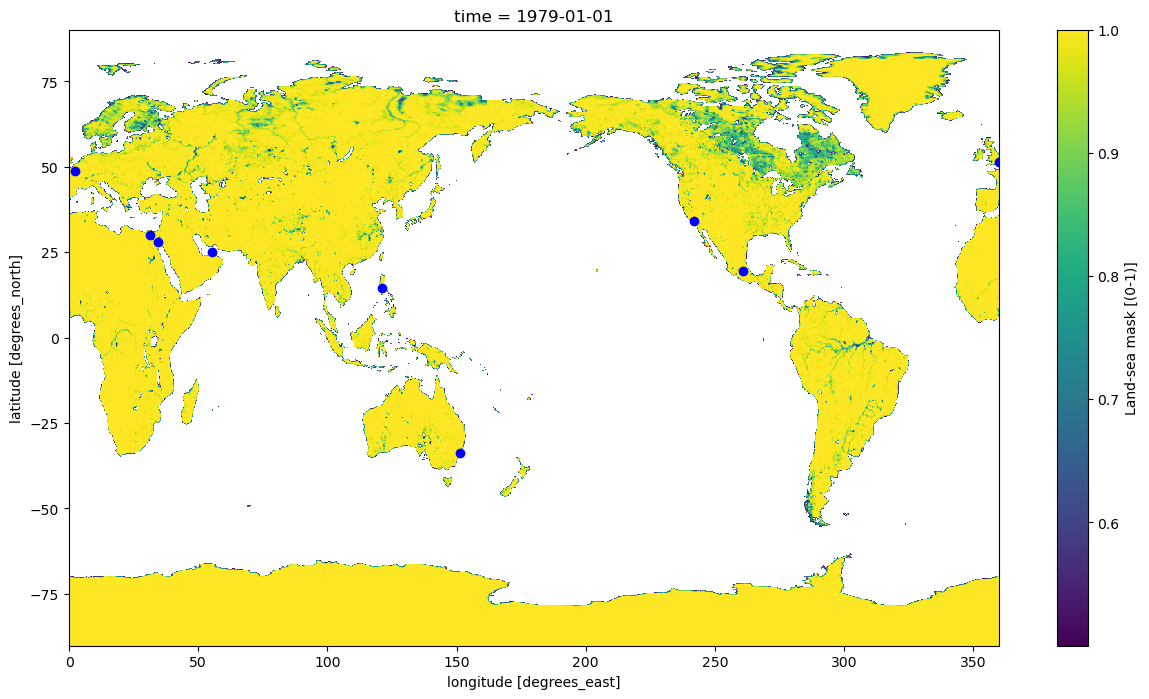

In [32]:
#proj = ccrs.PlateCarree()
import matplotlib.pyplot as plt 
flnm_mask = '/glade/collections/rda/data/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'
with  xr.open_dataset(flnm_mask) as ds:
    lsm = ds['LSM']
    lsm =lsm.where(lsm>0.5) #.fillna(0)[0]
    lsm.plot(figsize=(15,8))
    # add locations (points) to the map
    plt.plot(np.array(lon_1d), np.array(lat_1d), 'bo')
    # make sure they are over land
    for nc in range(n_city):
        print(city_s[nc], 'lsm', lsm.sel(latitude=lat_1d[nc], longitude=lon_1d[nc], method="nearest").values
             , 'lat', lat_1d[nc],'lon',lon_1d[nc])        

#### extract time series over those cities 

In [34]:
# hourly variables
var_f = ['2t', '2d','10u', '10v']
var_s = ['VAR_2T', 'VAR_2D', 'VAR_10U', 'VAR_10V']
#var_f = ['2t']
#var_s = ['VAR_2T']

n_var = len(var_s) 

dir_i = '/glade/collections/rda/data/ds633.0/e5.oper.an.sfc/'

In [35]:
year_s = 1979
year_e = 2020

StartDay = datetime.datetime(year_s, 1, 1, 0)
StopDay  = datetime.datetime(year_e, 12, 31, 23)
TimeHH = pd.date_range(StartDay, end=StopDay, freq='1h')
print('n_hours:', len(TimeHH), ' between', StartDay, 'and', StopDay)
    
#for nv in range(1):    
for nv in range(len(var_f)):
    flnm_o = 'DATA/' + var_f[nv] + '.csv'
    if os.path.exists(flnm_o): 
        print(flnm_o, 'exist')
        continue
    var_new = np.zeros((n_city))
    var_new = var_new [None,:]
    for year in range(year_s, year_e + 1):
        for month in range(1,12+1):
            print(year, month, var_f[nv])
            
            FILE = glob.glob(dir_i + str(year) + str(month).zfill(2) + '/*_' + var_f[nv] + '*.nc')[0]
            
            with xr.open_dataset(FILE) as ds:
                print('FILE=', FILE)
                
                var_3d = ds[var_s[nv]]
                 
                var_2d = np.zeros((var_3d.shape[0],n_city)) 
                
                for nc in range(n_city):
                    val_1d = var_3d.sel(latitude=lat_1d[nc], longitude=lon_1d[nc], method="nearest").values
                    #print(len(val_1d))
                    var_2d[:,nc] = val_1d              
                var_new = np.append(var_new, var_2d, axis=0)
    df = pd.DataFrame(var_new[1:], columns = city_s)
    df = df.set_index(TimeHH)
    df.plot(title=var_s[nv])
    df.to_csv(flnm_o)  
print('SUCCEED')

n_hours: 368184  between 1979-01-01 00:00:00 and 2020-12-31 23:00:00
DATA/2t.csv exist
DATA/2d.csv exist
DATA/10u.csv exist
DATA/10v.csv exist
SUCCEED


##### formate csv file for James

In [10]:
format_9city_csv('/glade/u/home/mingge/HEAT/DATA/2t.csv', '/glade/u/home/mingge/HEAT/2t.csv')
format_9city_csv('/glade/u/home/mingge/HEAT/DATA/2d.csv', '/glade/u/home/mingge/HEAT/2d.csv')
format_9city_csv('/glade/u/home/mingge/HEAT/DATA/10u.csv', '/glade/u/home/mingge/HEAT/10u.csv')
format_9city_csv('/glade/u/home/mingge/HEAT/DATA/10v.csv', '/glade/u/home/mingge/HEAT/10v.csv')

In [3]:
format_9city_csv('/glade/u/home/mingge/HEAT/DATA/twb.csv', '/glade/u/home/mingge/HEAT/twb.csv')

#### Plot for verification

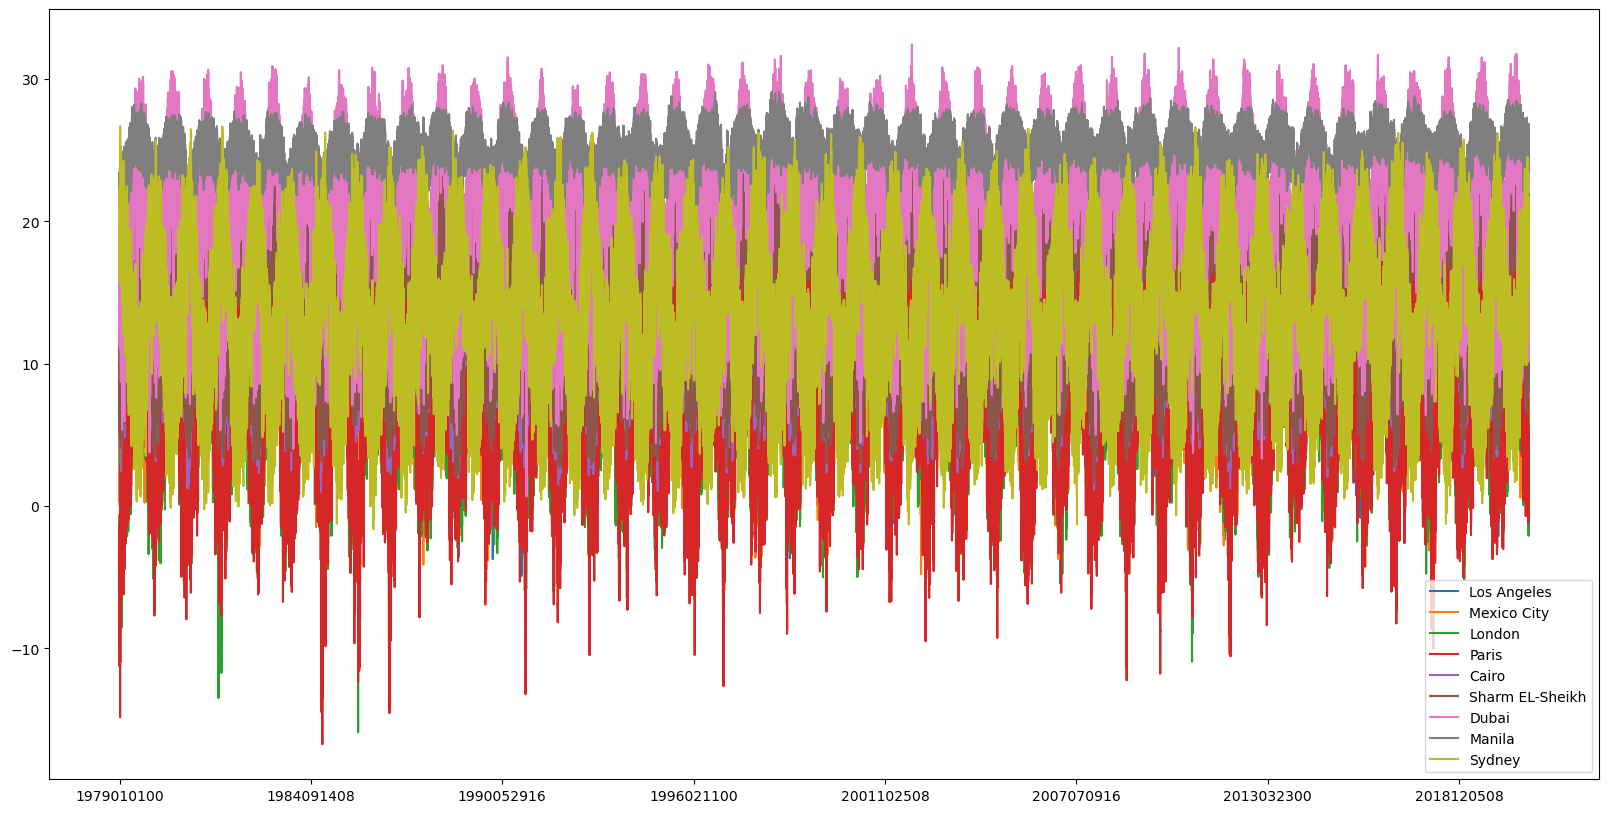

In [4]:
plot_9city('/glade/u/home/mingge/HEAT/DATA/twb.csv')

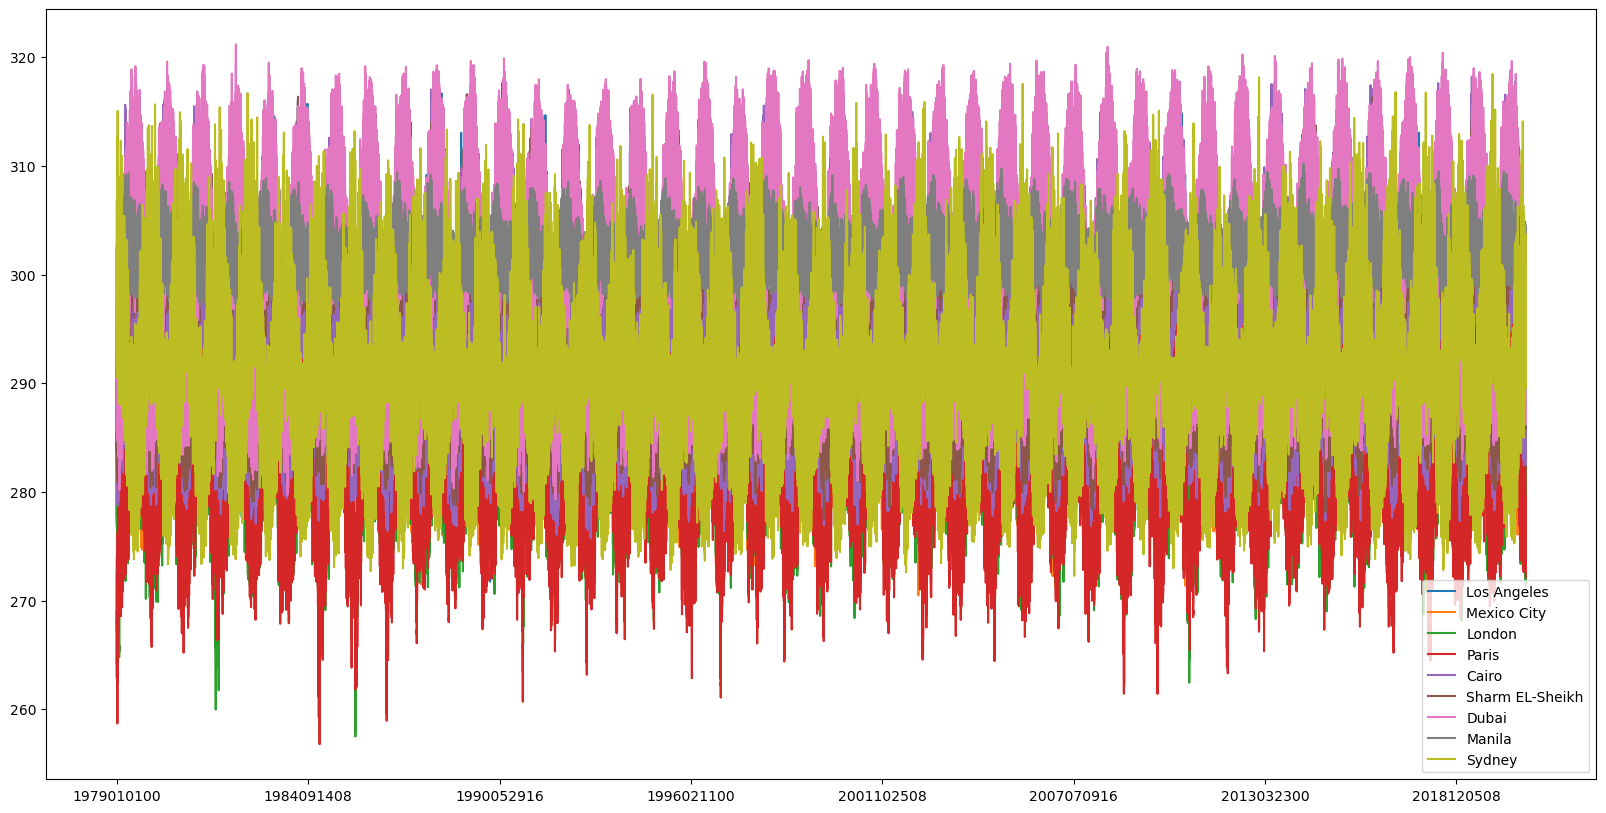

In [15]:
plot_9city('/glade/u/home/mingge/HEAT/DATA/2t.csv')

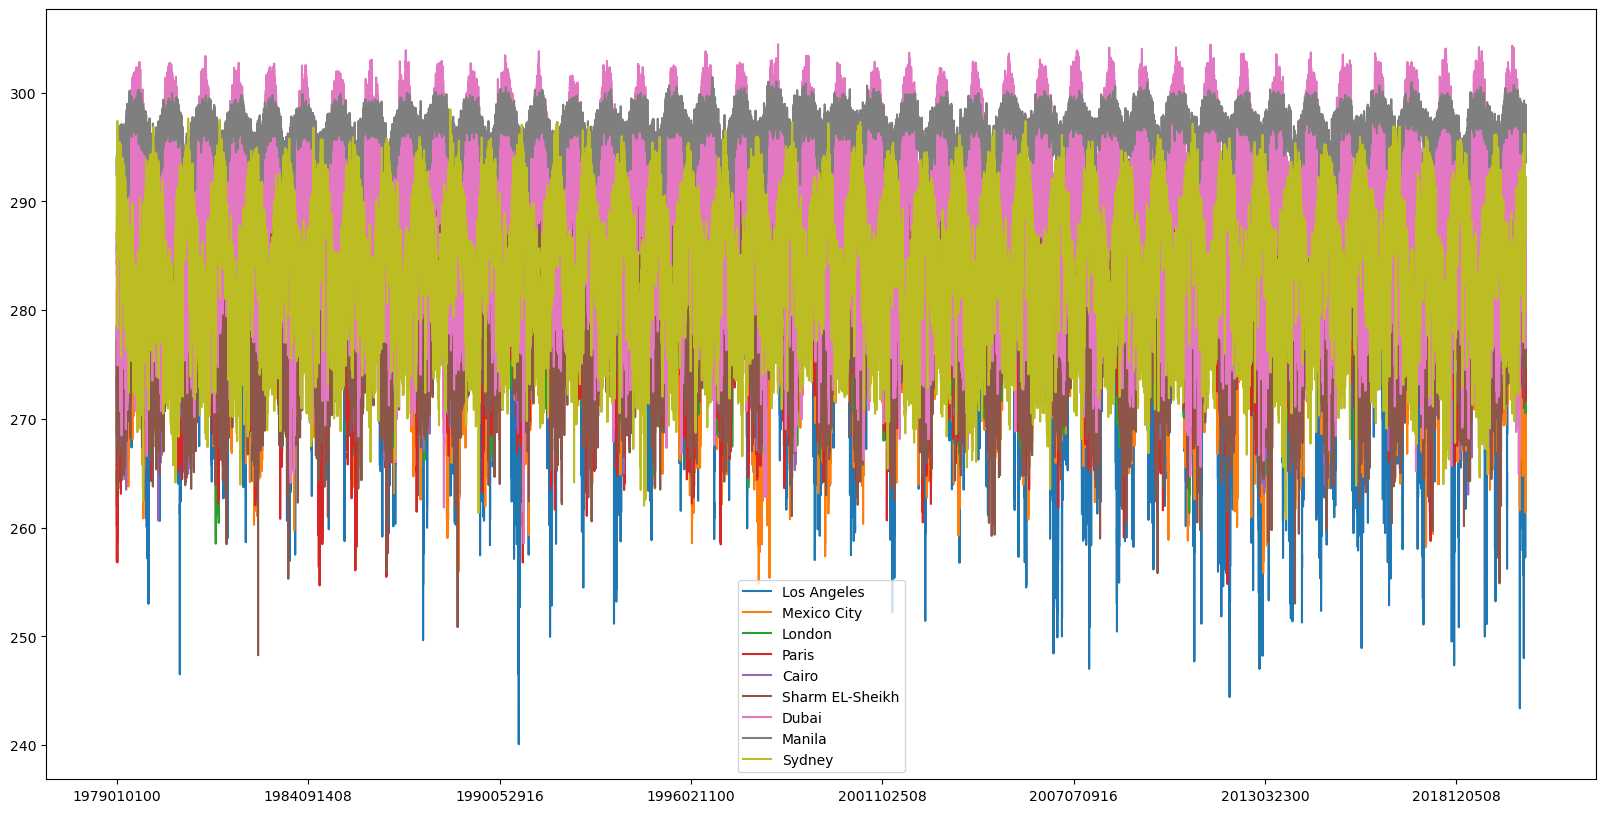

In [16]:
plot_9city('/glade/u/home/mingge/HEAT/DATA/2d.csv')

RangeIndex(start=0, stop=368184, step=1)

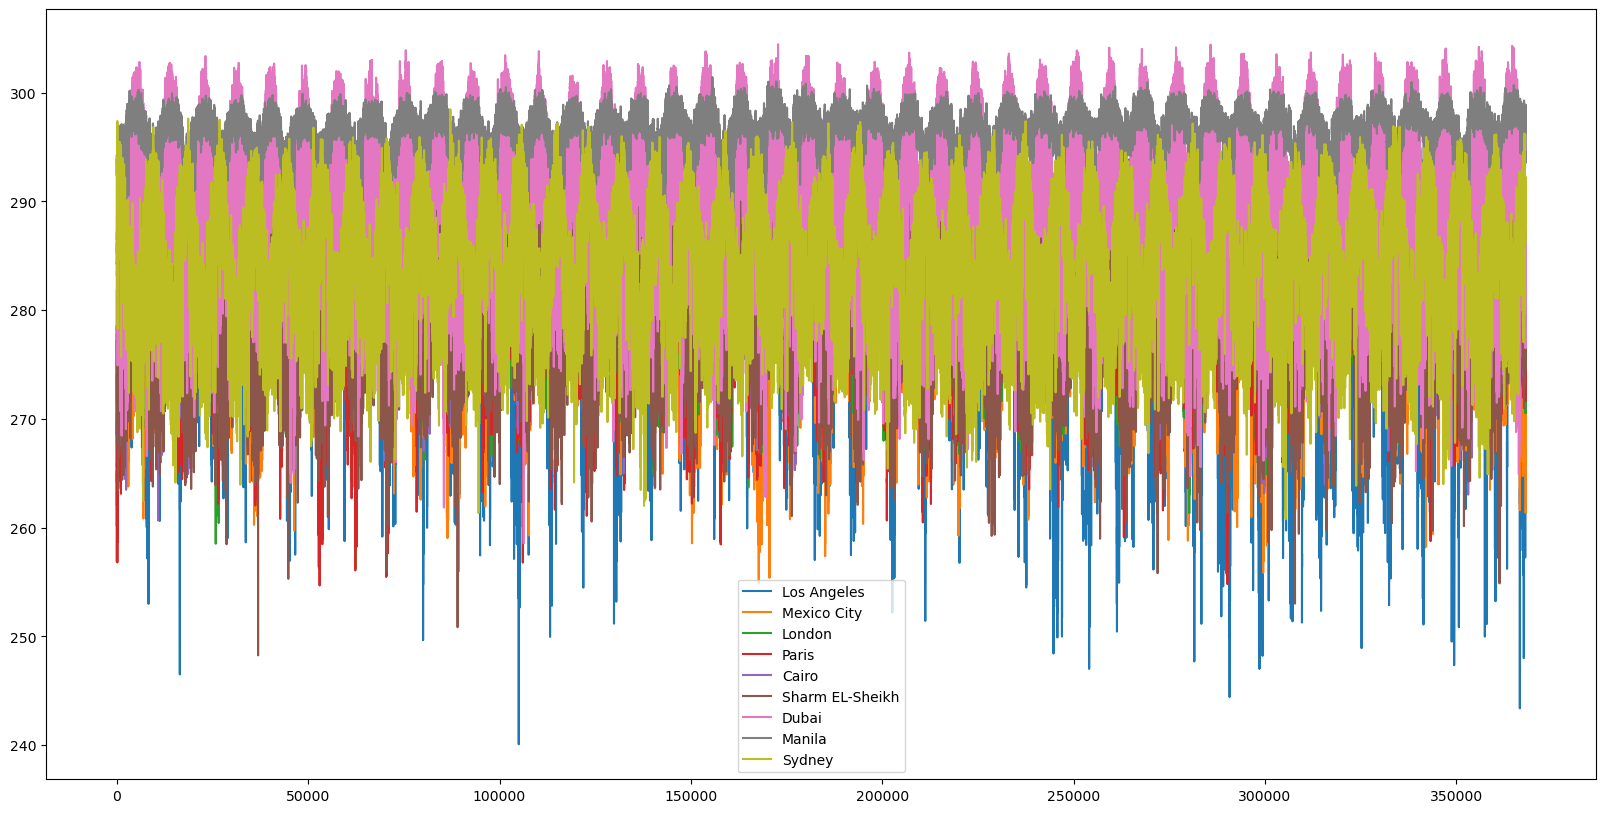

In [14]:
#plot_9city_new('/glade/u/home/mingge/HEAT/2t.csv')
flnm = '/glade/u/home/mingge/HEAT/2d.csv'
df_d = pd.read_csv(flnm, index_col = 0)
   
# Drop a Pandas Dataframe index with `.reset_index()
df_d = df_d.reset_index(drop=True)
df_d.plot(figsize=(20, 10))
df_d.index

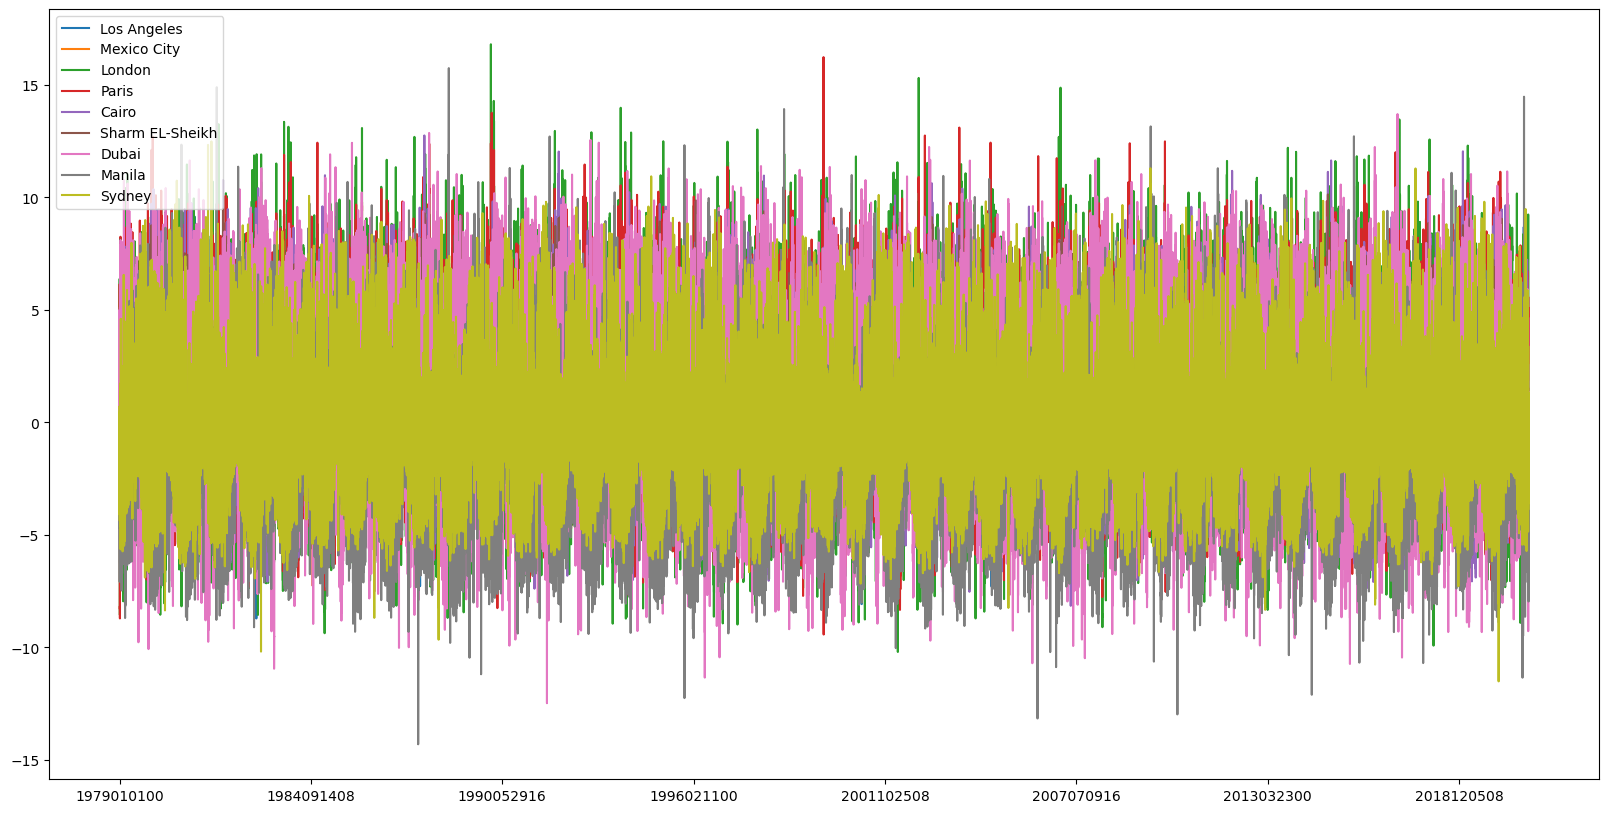

In [17]:
plot_9city('/glade/u/home/mingge/HEAT/DATA/10u.csv')

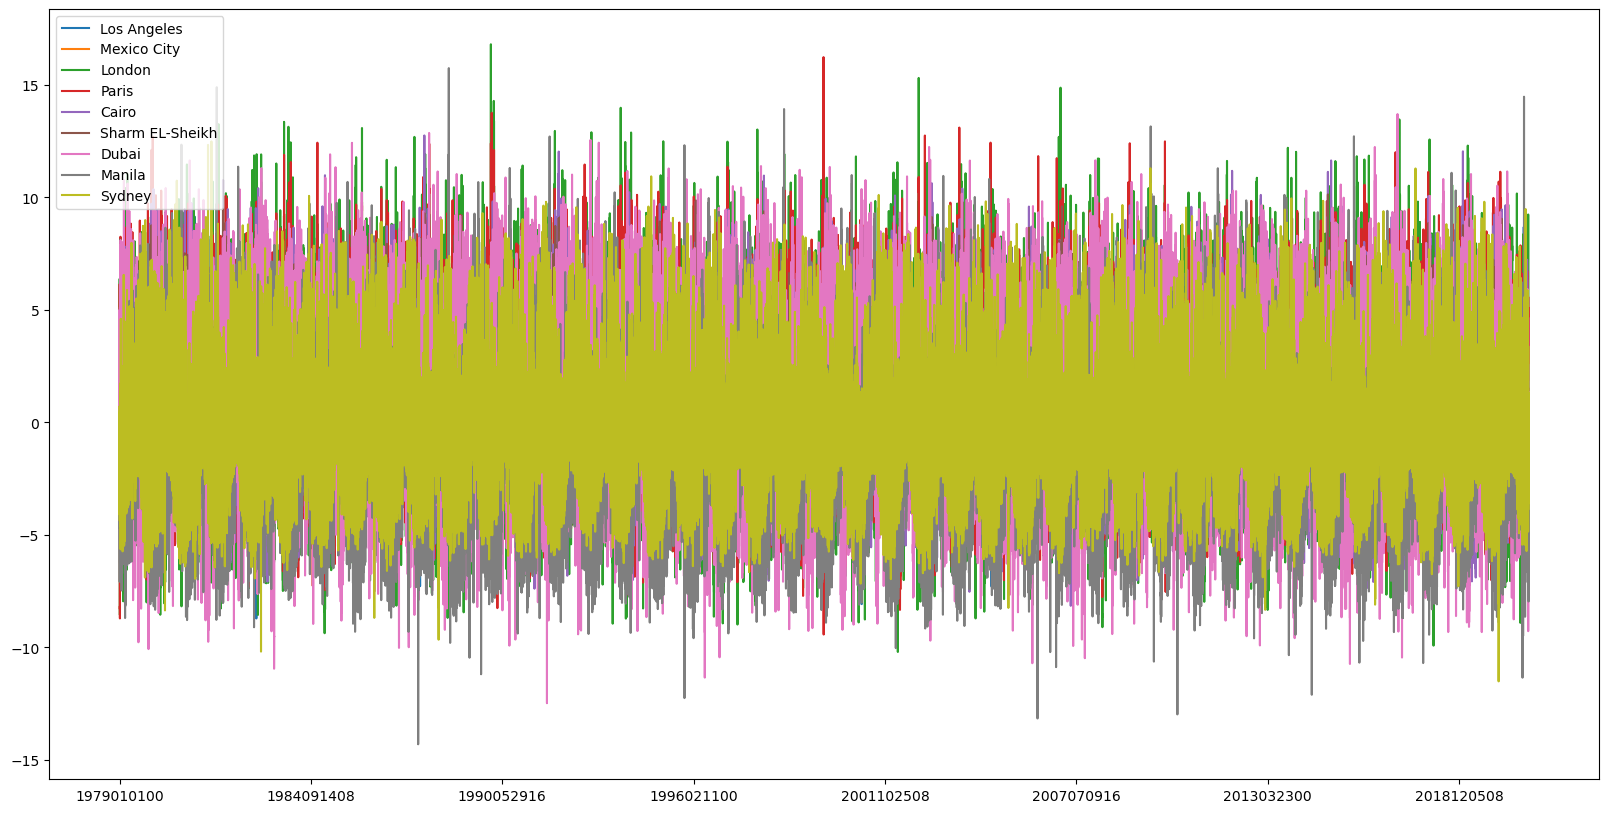

In [18]:
plot_9city('/glade/u/home/mingge/HEAT/DATA/10u.csv')

#### Task 2
 - get daily 2m wet-bulb temperature timeseries data from hourly by resampling

In [36]:
# hourly data -> daily TWBmax 
flnm = '/glade/u/home/mingge/HEAT/DATA/twb.csv'
df_twb = pd.read_csv(flnm, index_col = 0)

#convert index to datetime
df_twb.index = pd.to_datetime(df_twb.index)

# group hourly data into daily maximum
df_twb_daily = df_twb.resample('D').max()
df_twb_daily

,Los Angeles,Mexico City,London,Paris,Cairo,Sharm EL-Sheikh,Dubai,Manila,Sydney
1979-01-01,9.778473,13.069000,-5.454254,-4.958710,11.598083,11.008728,17.247650,23.423431,21.643951
1979-01-02,7.511871,10.503845,-1.264526,-0.601379,11.036316,11.185181,17.393585,22.370605,22.393066
1979-01-03,11.260498,9.117645,-1.356812,-2.098053,10.073303,13.461700,17.570862,23.185333,17.599670
1979-01-04,12.398621,9.427521,-0.726044,-3.555267,9.552948,13.094025,17.749237,23.742615,19.071411
1979-01-05,11.322784,9.989502,-2.806366,-4.733673,8.873260,10.983459,18.970093,23.045746,23.197021
...,...,...,...,...,...,...,...,...,...
2020-12-27,12.829620,7.979248,8.479828,5.761932,14.999542,15.825043,14.214661,24.561584,21.761993
2020-12-28,12.518677,7.381348,2.389496,3.596985,15.503876,15.308258,14.993103,26.389343,21.667328
2020-12-29,9.866486,8.502563,2.706818,4.182404,15.416168,14.951843,15.713715,26.862518,18.447113
2020-12-30,10.143188,9.946442,2.675568,4.587646,14.934235,15.637787,16.109009,26.771179,18.710052


#### work on df_twb_daily
 - using 28C 30C and P90 P99 threshold for each location
 - duration: count the number of times we get *consecutive sequences* of value=1
   - i) duration (days), 
   - ii) max value of wet-bulb temperature over the sequence, 
   - iii start date.

In [64]:
create_df(df_twb_daily.where(df_twb_daily>30.), '30C')

output: Dubai_30C.csv


In [65]:
create_df(df_twb_daily.where(df_twb_daily>28), '28C')

output: Dubai_28C.csv
output: Manila_28C.csv


#### using quantile

In [67]:
df_q = df_twb_daily.quantile([0.9])
df_q

,Los Angeles,Mexico City,London,Paris,Cairo,Sharm EL-Sheikh,Dubai,Manila,Sydney
0.9,20.68277,15.617462,16.743042,18.308472,22.889099,21.979004,28.616455,27.294281,21.577454


In [74]:
df_q = df_twb_daily.quantile([0.9])

# don't want to change the dataframe object I'm working on df_copy
df_copy = df_twb_daily.copy()
for (cityName, twb) in df_copy.iteritems():
    print(cityName, 'P90 ', df_q[cityName].values[0])
    df_copy[cityName]=df_twb_daily.where(df_twb_daily[cityName]>df_q[cityName].values[0])[cityName]   
    
create_df(df_copy, 'p90')   
df_q

Los Angeles P90  20.682769775390625
Mexico City P90  15.617462158203123
London P90  16.7430419921875
Paris P90  18.3084716796875
Cairo P90  22.88909912109375
Sharm EL-Sheikh P90  21.97900390625
Dubai P90  28.616455078125
Manila P90  27.29428100585937
Sydney P90  21.57745361328125
output: Los Angeles_p90.csv
output: Mexico City_p90.csv
output: London_p90.csv
output: Paris_p90.csv
output: Cairo_p90.csv
output: Sharm EL-Sheikh_p90.csv
output: Dubai_p90.csv
output: Manila_p90.csv
output: Sydney_p90.csv


,Los Angeles,Mexico City,London,Paris,Cairo,Sharm EL-Sheikh,Dubai,Manila,Sydney
0.9,20.68277,15.617462,16.743042,18.308472,22.889099,21.979004,28.616455,27.294281,21.577454


In [75]:
df_q99 = df_twb_daily.quantile([0.99])

df_copy = df_twb_daily.copy()

for (cityName, twb) in df_copy.iteritems():
    print(cityName, df_q99[cityName].values[0])
    df_copy[cityName]=df_twb_daily.where(df_twb_daily[cityName]>df_q99[cityName].values[0])[cityName] 
    
create_df(df_copy, 'p99')

df_q99

Los Angeles 23.31697998046875
Mexico City 16.906951904296875
London 20.05612182617188
Paris 21.96409301757813
Cairo 24.63937377929688
Sharm EL-Sheikh 24.062744140625004
Dubai 30.358587646484377
Manila 28.02366943359375
Sydney 24.38352661132813
output: Los Angeles_p99.csv
output: Mexico City_p99.csv
output: London_p99.csv
output: Paris_p99.csv
output: Cairo_p99.csv
output: Sharm EL-Sheikh_p99.csv
output: Dubai_p99.csv
output: Manila_p99.csv
output: Sydney_p99.csv


,Los Angeles,Mexico City,London,Paris,Cairo,Sharm EL-Sheikh,Dubai,Manila,Sydney
0.99,23.31698,16.906952,20.056122,21.964093,24.639374,24.062744,30.358588,28.023669,24.383527
